In [20]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

In [2]:
headers = ['engine_id','cycle', 'settings1','settings2','settings3'] + [f'sensor {i}' for i in range(1,24)]

In [3]:
#reading the data
df = pd.read_csv('train_FD001.txt', sep=' ', header=None, names=headers)

In [4]:
#checking for null values 
df.isnull().sum()

engine_id        0
cycle            0
settings1        0
settings2        0
settings3        0
sensor 1         0
sensor 2         0
sensor 3         0
sensor 4         0
sensor 5         0
sensor 6         0
sensor 7         0
sensor 8         0
sensor 9         0
sensor 10        0
sensor 11        0
sensor 12        0
sensor 13        0
sensor 14        0
sensor 15        0
sensor 16        0
sensor 17        0
sensor 18        0
sensor 19        0
sensor 20        0
sensor 21        0
sensor 22    20631
sensor 23    20631
dtype: int64

In [5]:
#remioving null values 
df.dropna(axis=1, inplace=True)

In [6]:
#descriptive statistics on the data
df.describe()

,engine_id,cycle,settings1,settings2,settings3,sensor 1,sensor 2,sensor 3,sensor 4,sensor 5,...,sensor 12,sensor 13,sensor 14,sensor 15,sensor 16,sensor 17,sensor 18,sensor 19,sensor 20,sensor 21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [7]:
sensor = [col for col in df.columns if 'sensor' in col]

In [8]:
#splitting the data into healthy vs unhealhy records
training = df[df['cycle']<=50]
test = df[df['cycle']>50]

In [9]:
#using a RobusteSCaler to handle non-gaussian distribution (from domain knowledge)
#only transforming sensor data since they are main determinants of degradation
scaler = RobustScaler()
X = scaler.fit_transform(training[sensor])

In [10]:
#defining a sequence for the LSTM model 
def sequences(data, window):
    sequences = []
    for i in range(len(data) - window):
        seq = data[i:i+window]
        sequences.append(seq)
    return np.array(sequences)
        

In [11]:
X_train = sequences(X, window =20) 

In [12]:
X_train.shape

(4980, 20, 21)

In [13]:
#defining the LSTM Autoencoder

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
encoder = LSTM(64, activation = 'relu', return_sequences=False)(inputs)

latent = RepeatVector(X_train.shape[1])(encoder)

decoder = LSTM(64, activation='relu', return_sequences=True)(latent)
outputs = TimeDistributed(Dense(X_train.shape[2]))(decoder)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 20, 21)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          22,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 20, 21)              │           1,365 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,405 (220.33 KB)

 Trainable params: 56,405 (220.33 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
#training the model 
training = model.fit(
X_train, X_train,
epochs=50,
batch_size=32,
validation_split=0.1,
shuffle=True)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.2282 - val_loss: 0.2051
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1960 - val_loss: 0.1922
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.1858 - val_loss: 0.1856
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1825 - val_loss: 0.1867
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1813 - val_loss: 0.1828
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1783 - val_loss: 0.1802
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.1758 - val_loss: 0.1788
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.1741 - val_loss: 0.1761
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.1727 - val_loss: 0.1761
Epoch 10/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1717 - val_loss: 0.1758
Epoch 11/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1708 - val_loss: 0.1762
Epoch 12/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 

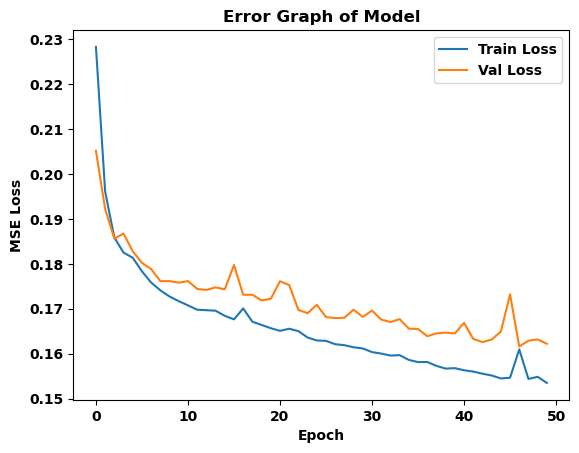

In [15]:
plt.plot(training.history['loss'], label='Train Loss')
plt.plot(training.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Error Graph of Model')
plt.legend()
plt.show()

In [16]:
#calculating the Reconstruction Error of each engine 

engines = test['engine_id'].unique()
engine_loss ={}
for e in engines:
    e_data = test[test['engine_id']==e][sensor].values
    
    e_data_scaled = scaler.transform(e_data)
    
    e_data_sq = sequences(e_data_scaled, window=20)
    
    e_pred = model.predict(e_data_sq)
    
    e_loss = np.mean(np.abs(e_pred - e_data_sq), axis=(1,2))
    
    engine_loss[e]= e_loss

C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\sehal\anaconda3\envs\house_price_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [17]:
#defining the thresholds and anaomalies for each engine

thresholds = {e: np.percentile(e_loss, 99) for e, e_loss in engine_loss.items()}
anomalies = {e:e_loss>thresholds[e] for e, e_loss in engine_loss.items()}

<class 'numpy.ndarray'>
(199,)
199 199 199


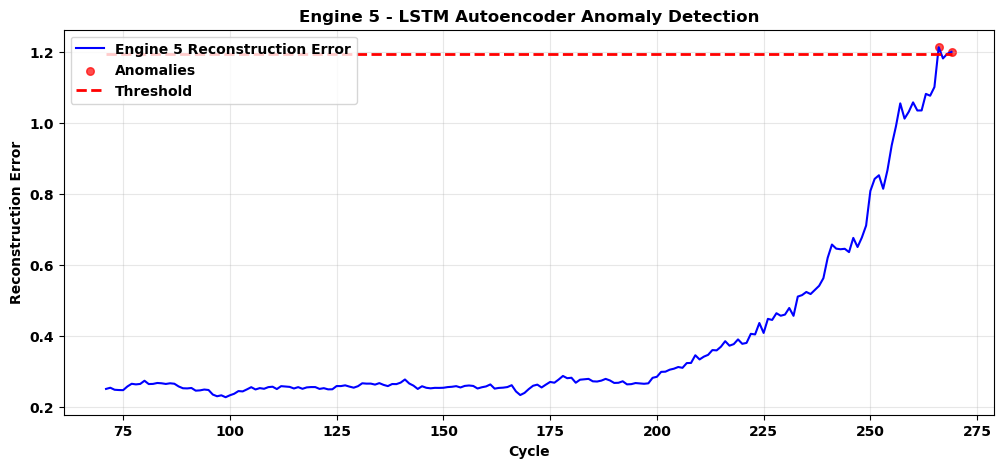

In [18]:
#evalaution of the Anomaly detection model through visual inspection
e =5
engine_cycles = test[test['engine_id']==e]['cycle'].values

window = 20

error_cycles = engine_cycles[window:]
loss_x =engine_loss[e]
anomalie_x = anomalies[e]
threshold_e =thresholds[e]
print(type(anomalie_x))
print(np.shape(anomalie_x))

print(len(loss_x), len(error_cycles), len(anomalie_x))

plt.figure(figsize=(12,5))
plt.plot(error_cycles, loss_x,label=f'Engine {e} Reconstruction Error', color='blue')
plt.scatter(error_cycles[anomalie_x], loss_x[anomalie_x], color='red', s=30, label='Anomalies', alpha=0.7)
plt.hlines(threshold_e, xmin=error_cycles[0], xmax=error_cycles[-1], colors='red', linestyles='--', linewidth=2, label='Threshold')
plt.title(f'Engine {e} - LSTM Autoencoder Anomaly Detection')
plt.xlabel('Cycle')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


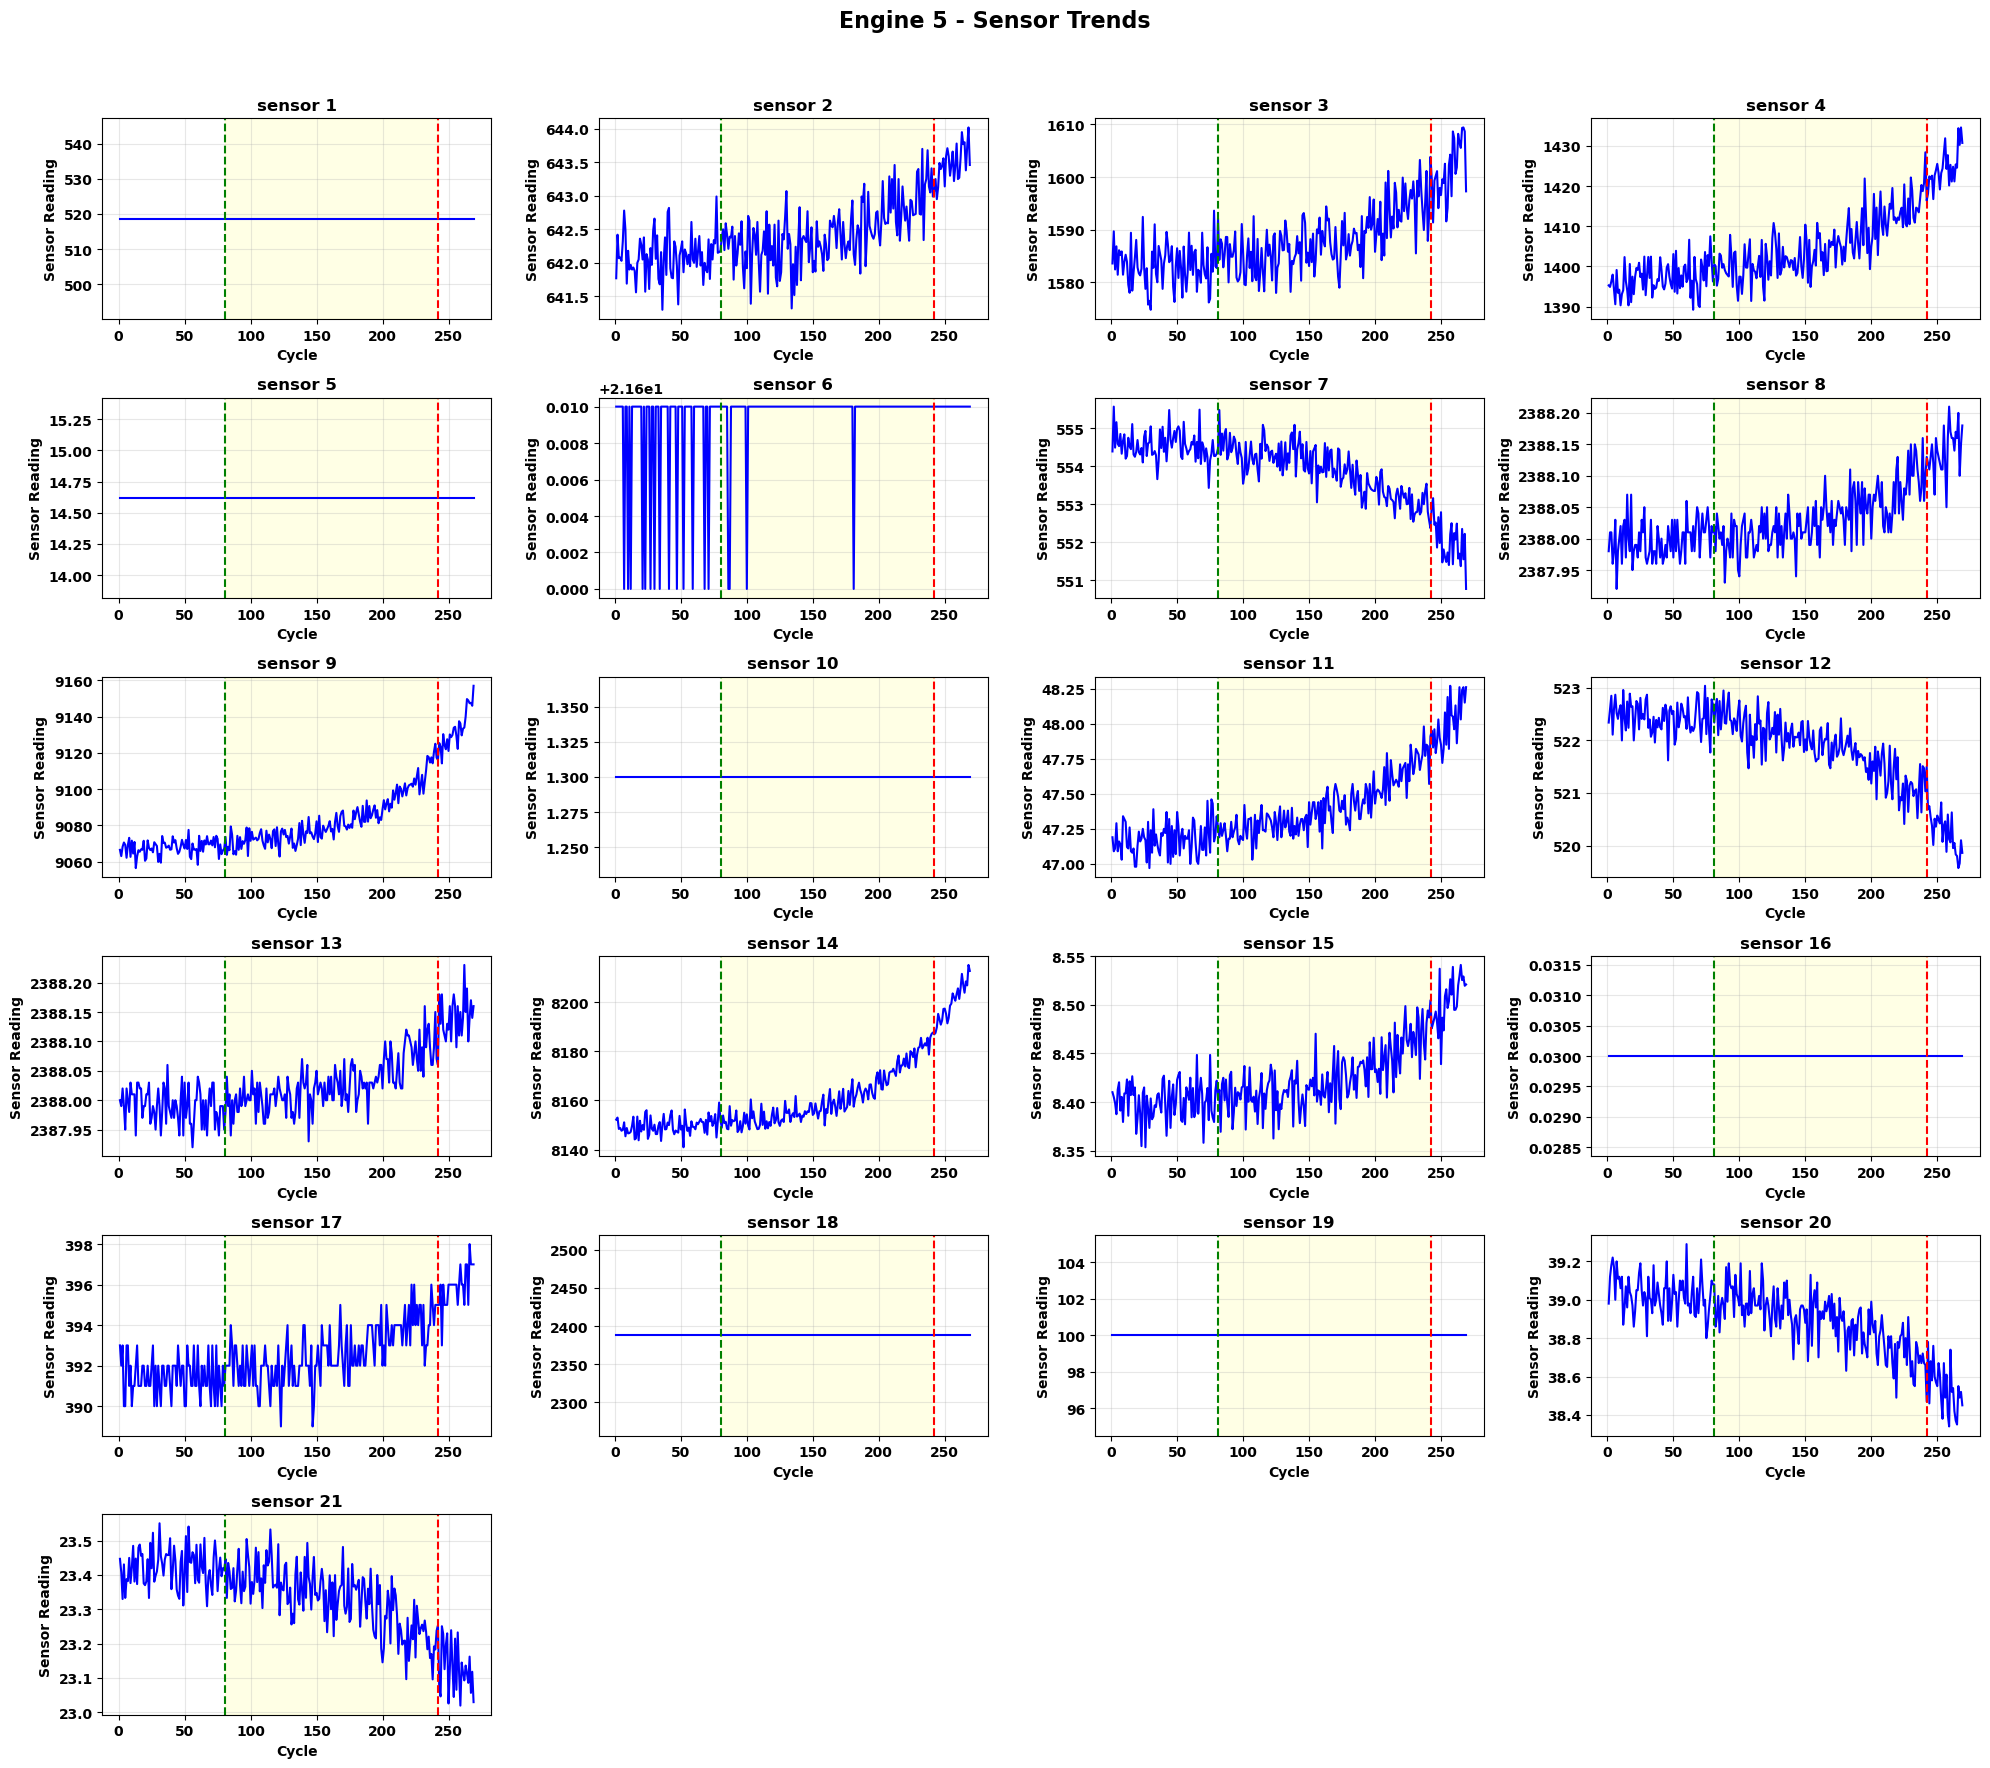

In [19]:
#visualizing trend of sensor for chosen engine over the number of cycles
engine_id = 5  # choosing the engine to analyse


# Extract engine data
engine_data = df[df['engine_id'] == engine_id]
cycles = engine_data['cycle'].values
max_cycle = engine_data['cycle'].max()

num_sensors = len(sensor)
num_cols = 4
num_rows = math.ceil(num_sensors / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 3*num_rows))
axes = axes.flatten()  # flatten to 1D array for easy iteration

for idx, s in enumerate(sensor):
    ax = axes[idx]
    ax.plot(cycles, engine_data[s], color='blue')
    ax.axvline(x=max_cycle*0.3, color='green', linestyle='--')# defining the point after which health degradation begins 
    ax.axvline(x=max_cycle*0.9, color='red', linestyle='--')# defining the point after which failure degradation occurs
    ax.axvspan(max_cycle*0.3, max_cycle*0.9, color='yellow', alpha=0.1) #area of acceptable degradation due to wear and tear
    ax.set_title(f'{s}')
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Sensor Reading')
    ax.grid(alpha=0.3)

# Hide any unused subplots
for idx in range(len(sensor), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle(f'Engine {engine_id} - Sensor Trends', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()